### MAPEO ESPACIAL DE DIMENSIONES

* Ladino Álvarez Ricardo Arturo

**Partes del Notebook**

- Librerias
- Lectura de datos
  - Base de datos con dimensiones
  - Base de datos geoespacial
- Selección de unidad por tabla interactiva
- Función Spatial_Table
  - Tabla de datos geoespaciales
- Función Spatial_Maps
  - Mapeo de dimensiones estáticas


* **IMPORTANTE**: El código esta conformado por tres funciones (Ui_Table,Spatial_Table y Spatial_Maps_01), las cuales se pueden guardar en un documento .py para ser modificadas y compiladas cuando se requiera.

     * La modificación del código permite generar rutas de exportación para las imagenes de los mapas resultados. El mapa general es recortado en termino de cada una de las dimensiones analizadas para uso individual.

### Librerias

In [1]:
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
### Librerias
#-------------------------------------------------------------------------------------------------------------------------#
import os ### Permite realizar operaciones dependiente del Sistema Operativo (crear una carpeta, listar contenidos, etc.)
import glob ### encuentra todos los nombres de rutas especificadas de acuerdo a las reglas que se siguen en una terminal
import functools  ### Para funciones de orden superior: funciones que actúan o retornan otras funciones
import numpy as np ### Para tranformaciones númericas (matrices)
import pandas as pd  ### Para manipulación y análisis de datos
from PIL import Image ### Para manipulación de imagenes
import geopandas as gpd  ### Manipulación de datos Geoespaciales (SHP,GeoCSV, GeoDataFrame, GeoJson)
import matplotlib as mpl  ##  Para normalizar escalas de colores que se elaboran por usuario
import ipywidgets as widgets ### Creación de controles de interfaz de usuario (UI) para explorar de forma interactiva. 
import branca.colormap as cm  ### Módulo de utilidad para el manejo de mapas de colores.
import matplotlib.pyplot as plt ### Colección de herramientas para generar graficos.
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm ### Subconjunto de matplotlib para definir función escala en colores

### Lectura de datos

In [2]:
#-------------------------------------------------------------------------------------------------------------------------#
### Tabla de dimensiones
### Cambio en las dimensiones de texto que entran 
Marc_Maps = pd.read_excel('D:/Users/LAAR8976/Desktop/Ladino/Fidel/20220315MAPAS.xlsx')


#-------------------------------------------------------------------------------------------------------------------------#
### Alineaciones
### Se alinean las unidades con base a las geográfias que también han sido alineadas en los nuevos poligonos 
Marc_Maps = Marc_Maps.replace({'UNIDAD' : { 'BAJA CALIFORNIA 3' : 'BAJA CALIFORNIA 2', 
                                           'BAJA CALIFORNIA SUR 2' : 'BAJA CALIFORNIA SUR 1',
                                           'GUANAJUATO 1' : 'GUANAJUATO 3',
                                          'GUERRERO 2':'GUERRERO 1', 'JALISCO 4':'JALISCO 3', 'JALISCO 5':'JALISCO 2',
                                           'MICHOACAN 2':'MICHOACAN 1','QUINTANA ROO 1':'QUINTANA ROO 2',
                                           'SINALOA 3':'SINALOA 1', 'TAMAULIPAS 2':'TAMAULIPAS 3', 'VERACRUZ 3':'VERACRUZ 2',
                                           'VERACRUZ 5':'VERACRUZ 1'}})

#print(Marc_Maps.shape)
#Marc_Maps.head(2)
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
### Archivo espacial
Spatial = gpd.read_file('LOCALES.geojson')
Spatial = Spatial.drop(['id'], axis=1)
#Spatial.plot()
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
GeoLocations = gpd.read_file('GeoLocations.geojson')
GeoLocations = GeoLocations.drop(['id'], axis=1)
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#


### Selección de unidad por tabla interactiva

In [3]:
#-------------------------------------------------------------------------------------------------------------------------#
#### Serie de funciones para tabla interactiva
#-------------------------------------------------------------------------------------------------------------------------#
def Ui_Table(Marc_Maps):
#-------------------------------------------------------------------------------------------------------------------------#
#### Input:
######  >>> Marc_Maps = Tabla de dimensiones inicial
#-------------------------------------------------------------------------------------------------------------------------#    
### output_dataframe
### Proceso
######  >> A) output_dataframe: crea la tabla donde se guardara toda la información filtrada
######  >> B) ALL: se utiliza para seleccionar toda la información dentro de la dimensión de uso
    output_dataframe = None
    ALL = 'ALL'
#-------------------------------------------------------------------------------------------------------------------------#    
### unique_sorted_values_plus_ALL
### Proceso
######  >> A) La subfunción genera una lista con base a toda la información contenida dentro de una dimensión.
######          >>> A.1) unique(...): De la columna extraer las descripciones unicas para transformar en una lista
######  >> B) return unique: lista de valores unicos dentro de una dimensión
#-------------------------------------------------------------------------------------------------------------------------# 
    def unique_sorted_values_plus_ALL(array):
        unique = array.unique().tolist()
        unique.sort()
        unique.insert(0, ALL)
        return unique
#-------------------------------------------------------------------------------------------------------------------------#
### output
### Proceso
######  >> A) output: corresponde a la salida visual de la tabla interactiva al aplicar filtros
#-------------------------------------------------------------------------------------------------------------------------#    
    output = widgets.Output()
#-------------------------------------------------------------------------------------------------------------------------#
### Lista de Dropdown
### Proceso
######  >> A) widgets.Dropdown: genera las ventanas emergentes de selección con base a las dimensiones seleccionadas
#-------------------------------------------------------------------------------------------------------------------------#    
    AMBITO = widgets.Dropdown(description='AMBITO', options = unique_sorted_values_plus_ALL(Marc_Maps.AMBITO))
    ADM_GRAL = widgets.Dropdown(description='ADM_GRAL', options = unique_sorted_values_plus_ALL(Marc_Maps.ADM_GRAL))
    
#-------------------------------------------------------------------------------------------------------------------------#
### common_filtering
### Proceso
######  >> A) common_filtering("dimension 00", "dimension 01", "dimensio n-1"): utiliza la serie de listas Dropdown
######  >> B) global: relacionada a la tabla de salida filtrada como variable global
######  >> C) filters = []: crea un vector que guarda la información de los filtros seleccionados
######  >> C) if : si lista Dropdown no es nula despliega la información y selecciona sobre los valores
######  >> D) with : se genera la tabla visual interactiva con base a los resultados en los filtros
######  >> E) if - else (with) : tabla visual de resultados
#-------------------------------------------------------------------------------------------------------------------------#    
    def common_filtering(AMBITO, ADM_GRAL):
        global output_dataframe
        df = Marc_Maps.copy()
        filters = []
        if AMBITO is not ALL:
            filters.append(df['AMBITO'] == AMBITO)
        if ADM_GRAL is not ALL:
            filters.append(df['ADM_GRAL'] == ADM_GRAL)
        output.clear_output()
        with output:
            if filters:
                df_filter = functools.reduce(lambda x,y: x&y, filters)
                display(df.loc[df_filter])
                output_dataframe = df.loc[df_filter]
            else:
                display(df)
#-------------------------------------------------------------------------------------------------------------------------#
### dropdown_dimensión_eventhandler
### Proceso
######  >> A) Aplica la función de filtro "common_filtering" sobre las dimensiones como una nueva función
######  >> B) dimension.observe: Exibe los resultados del filtrado en la dimensión
######  >> C) widgets.HBox: crea la descripción personalizada del marco integrado
######  >> D) display: muestra el marco de trabajo, listas Dropdown y tabla de salida output resultado del filtrado
#-------------------------------------------------------------------------------------------------------------------------#    
    def dropdown_AMBITO_eventhandler(change):
        common_filtering(change.new, ADM_GRAL.value)
        
    def dropdown_ADM_GRAL_eventhandler(change):
        common_filtering(AMBITO.value, change.new)
        
    AMBITO.observe(dropdown_AMBITO_eventhandler, names='value')
    ADM_GRAL.observe(dropdown_ADM_GRAL_eventhandler, names='value')
    
    ui = widgets.HBox([AMBITO,ADM_GRAL])
    display(ui, output)
#-------------------------------------------------------------------------------------------------------------------------#
#### Output:
######  >>> output_dataframe = Tabla de resultados filtrados   
    return(output_dataframe)
#-------------------------------------------------------------------------------------------------------------------------#

In [4]:
#-------------------------------------------------------------------------------------------------------------------------#
#### Ejecucion de funcion Ui_Table
output_dataframe = Ui_Table(Marc_Maps)
#-------------------------------------------------------------------------------------------------------------------------#

Output()

### Tabla de datos geoespaciales: Función Spatial_Table

In [5]:
(output_dataframe.UNIDAD.unique())

array(['GUANAJUATO 2', 'GUANAJUATO 3', 'GUERRERO 1', 'HIDALGO 1',
       'JALISCO 1', 'JALISCO 2', 'JALISCO 3', 'MEXICO 1', 'MEXICO 2',
       'MICHOACAN 1', 'MORELOS 1', 'NAYARIT 1', 'NUEVO LEON 1',
       'NUEVO LEON 2', 'NUEVO LEON 3', 'OAXACA 1', 'AGUASCALIENTES 1',
       'PUEBLA 1', 'PUEBLA 2', 'QUERETARO 1', 'QUINTANA ROO 2',
       'SAN LUIS POTOSI 1', 'SINALOA 1', 'SINALOA 2', 'SONORA 1',
       'SONORA 2', 'SONORA 3', 'TABASCO 1', 'TAMAULIPAS 1',
       'TAMAULIPAS 3', 'TAMAULIPAS 4', 'TAMAULIPAS 5', 'TLAXCALA 1',
       'VERACRUZ 1', 'VERACRUZ 2', 'VERACRUZ 4', 'BAJA CALIFORNIA 1',
       'BAJA CALIFORNIA 2', 'YUCATAN 1', 'ZACATECAS 1',
       'CIUDAD DE MÉXICO 1', 'CIUDAD DE MÉXICO 2', 'CIUDAD DE MÉXICO 3',
       'CIUDAD DE MÉXICO 4', 'BAJA CALIFORNIA SUR 1', 'CAMPECHE 1',
       'COAHUILA DE ZARAGOZA 1', 'COAHUILA DE ZARAGOZA 2',
       'COAHUILA DE ZARAGOZA 3', 'COLIMA 1', 'CHIAPAS 1', 'CHIAPAS 2',
       'CHIHUAHUA 1', 'CHIHUAHUA 2', 'DURANGO 1'], dtype=object)

In [6]:
#-------------------------------------------------------------------------------------------------------------------------#
### Función para tabla de datos geoespaciales
#-------------------------------------------------------------------------------------------------------------------------#
def Spatial_Table (out_dataframe, Espacial):
#-------------------------------------------------------------------------------------------------------------------------#
#### Input:
######  >>> out_dataframe = Tabla filtrada: Tabla resultado del proceso en tabla interactiva
######  >>> Espacial = Tabla geoespacial: Archivo geoespacial de las unidades
#-------------------------------------------------------------------------------------------------------------------------#
### Proceso
######  >> A) Utiliza out_dataframe y calcula en cada "Value_X" el promedio de la dimensión con respecto a su unidad
######          >>> A.1) out_dataframe.groupby('UNIDAD')['IRPC'].mean()
######  >> B) El resultado del proceso en "A" por estructura de agrupamiento se resetea en el index para crear el dataframe
######          >>> A.2) .reset_index()
#-------------------------------------------------------------------------------------------------------------------------#
    Value_IRPC = pd.DataFrame(out_dataframe.groupby('UNIDAD')['IRPC'].mean()).reset_index()
    Value_RFUN = pd.DataFrame(out_dataframe.groupby('UNIDAD')['RIESGO_FUNCIONES'].mean()).reset_index()
    Value_EXPE = pd.DataFrame(out_dataframe.groupby('UNIDAD')['EXPEDIENTES'].sum()).reset_index()
    Value_RGAU = pd.DataFrame(out_dataframe.groupby('UNIDAD')['RIESGO_UA'].mean()).reset_index()
    Value_PREVE = pd.DataFrame(out_dataframe.groupby('UNIDAD')['Resultado_PREVE'].mean()).reset_index()
    #Value_EMPLE= pd.DataFrame(output_dataframe.groupby('UNIDAD')['EMPLEADO'].size()).reset_index()
    Value_EMPLE = pd.DataFrame(output_dataframe.query('Obs_PREVE =="NO APROBADO"').groupby('UNIDAD')['EMPLEADO'].size()).reset_index()
    
    
#-------------------------------------------------------------------------------------------------------------------------#
### Proceso
######  >> A) Multiple Merge: Se crea una tabla única a partir de multiples merge con base a columna base (UNIDAD)
######          >>> A.1) merge(...)
######  >> B) Renombramiento: se lleva a cabo para ejecutar la unión entre tabla y archivo espacial por nombre columna
######          >>> A.1) rename(...)
######  >> C) Merge espacial: Ejecuta unión entre tabla y archivo espacial
######          >>> A.1) Espacial.merge()
######  >> D) Redondeo : redondeo de decimales en número de tipo flotante
######          >>> A.1) round({'Dimension': (número de decimales)})
#-------------------------------------------------------------------------------------------------------------------------#

    Total_Anual = Value_IRPC.merge(Value_RFUN, left_on='UNIDAD', right_on='UNIDAD',how='left').merge(Value_EXPE,left_on='UNIDAD', right_on='UNIDAD',how='left').merge(Value_RGAU,left_on='UNIDAD', right_on='UNIDAD',how='left').merge(Value_PREVE, left_on='UNIDAD', right_on='UNIDAD',how='left').merge(Value_EMPLE,left_on='UNIDAD', right_on='UNIDAD',how='left').fillna(0)
    Total_Anual = Total_Anual.rename({'UNIDAD':'LOCAL'}, axis=1)
    MAP_ALL = Espacial.merge(Total_Anual ,left_on='LOCAL', right_on='LOCAL',how='left').fillna(0)
    MAP_ALL = MAP_ALL.round({'IRPC': 2, 'RIESGO_FUNCIONES': 2, 'EXPEDIENTES':2, 'RIESGO_UA':2 , 'Resultado_PREVE':2, 'Value_EMPLE':2})
#-------------------------------------------------------------------------------------------------------------------------#
#### Output:
######  >>> MAP_ALL = Tabla Geoespacial con columnas relacionadas a: Unidad, dimensiones (IRPC,...,RIESGO_UA), Geometria
    return (MAP_ALL)
#-------------------------------------------------------------------------------------------------------------------------#

In [7]:
#-------------------------------------------------------------------------------------------------------------------------#
#### Ejecucion de funcion Geo_spatial
Geo_spatial = Spatial_Table(output_dataframe, Spatial)
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#

### Mapeo de dimensiones estáticas: Función Spatial_Maps

In [8]:
#------------------------------------------------------------------------------------------------------------------------#
### Función para mapeo de dimensiones estáticas n+1 
### Para cambiar la estructura se modifica ncols=2, nrows=2 en fig, axes
#------------------------------------------------------------------------------------------------------------------------#
def Spatial_Maps_01(Geo_spatial, out_dataframe, GeoLocations):
#------------------------------------------------------------------------------------------------------------------------#
#### Input:
######  >>> Geo_spatial = Tabla Geoespacial en la salida de la función Spatial_Table (Unidad, dimensiones, Geometria)
######  >>> out_dataframe = Tabla filtrada: Tabla resultado del proceso en tabla interactiva
#-------------------------------------------------------------------------------------------------------------------------#
### Proceso
######  >> A) Escala de colores: Definción de escala cromática de uso en mapas
######          >>> A.1) colormap
######  >> B) Estructura de la imagen: Tamaño, número, distancia entre cada uno y titulo para imagenes
######          >>> B.1)   fig, figsize, subplots_adjust, suptitle
######  >> C) Mapeo de dimensiones: Genera el mapa para cada dimensión, utilizando "Geo_spatial" y la dimensión 
######          >>> A.1) Geo_spatial.plot('Dimension'... 
######          >>> A.2) vmin=0, vmax=5 : normaliza valores en la escala para interpretaciones homologadas
######          >>> A.3) axes[0]: posicionamiento de imagen
#------------------------------------------------------------------------------------------------------------------------#

    colors = [[229, 231, 233], [84,130,53], [169,208,142], [235,230,0], [255,255,0], [255,192,0], [255,5,5], [130,0,0]]
    colors = np.array(colors)/255
    
    n_bin = 8
    n_bins_ranges = [0, 1, 1.58, 2.15, 2.72, 3.30, 3.87, 4.44, 5]
    cmap_name = 'SAT_MAP_INTERVAL'
    
    colormap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
    norm = BoundaryNorm(n_bins_ranges, len(n_bins_ranges))
    

    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(30,15))
    axes = axes.ravel()
    fig.subplots_adjust(wspace=0.001)
    fig.suptitle(list(output_dataframe.ADM_GRAL.unique()), fontsize=16)

#-------------------------------------------------------------------------------------------------------------------#
### Posicioón imagen izquiera superior


    axins = axes[0].inset_axes([0.45, 0.45, 0.6, 0.2])
    Geo_spatial.plot('IRPC', legend=True, cmap=colormap, norm=norm, ax=axes[0], 
                     alpha=1, linewidth = 0.05, edgecolor ='#1a1a1a',
                     legend_kwds={'label': "Valor de índice", 'orientation': "vertical", 'shrink': 0.8})
    Geo_spatial.plot('IRPC', legend=False, cmap=colormap, norm=norm, ax=axins, 
                     alpha=1, linewidth = 0.3, edgecolor ='#1a1a1a')
    axins.set(ylabel='', xlabel='', xlim=(-99.4647, -98.8495), ylim=(19.0102, 19.6090), xticks=[], yticks=[])
    axins.set_axis_off()
    axes[0].indicate_inset_zoom(axins)
    GeoLocations.plot(alpha=1, facecolor='black', linewidth=0, markersize=0.5, marker='v', ax=axes[0])
    #GeoLocations.apply(lambda x: axes[0].annotate(text=x['CLAVE_UNIDAD'], xy=x.geometry.centroid.coords[0],
                                                  #ha='left', fontsize = 2), axis=1)
    axes[0].set_title("IRPC") 
    axes[0].set_axis_off()

#---------------------------------------------------------------------------------------------------------------------#
### Posicioón imagen derecha superior

    axins_1 = axes[1].inset_axes([0.45, 0.45, 0.6, 0.2])
    Geo_spatial.plot('RIESGO_FUNCIONES', legend=True, cmap=colormap, norm=norm, ax=axes[1],
                     alpha=1,linewidth = 0.05, edgecolor ='#1a1a1a',
                     legend_kwds={'label': "Valor de índice", 'orientation': "vertical", 'shrink': 0.8})
    Geo_spatial.plot('RIESGO_FUNCIONES', legend=False, cmap=colormap, norm=norm, ax=axins_1,
                     alpha=1,linewidth = 0.3, edgecolor ='#1a1a1a')
    axins_1.set(ylabel='', xlabel='', xlim=(-99.4647, -98.8495), ylim=(19.0102, 19.6090), xticks=[], yticks=[])
    axins_1.set_axis_off()
    axes[1].indicate_inset_zoom(axins_1)
    #GeoLocations.plot(alpha=1, facecolor='black', linewidth=0, markersize=0.5, marker='v', ax=axes[1])
    #GeoLocations.apply(lambda x: axes[1].annotate(text=x['CLAVE_UNIDAD'], xy=x.geometry.centroid.coords[0],
                                                 # ha='left', fontsize = 2), axis=1)
    axes[1].set_title("RIESGO FUNCIONES") 
    axes[1].set_axis_off()

#---------------------------------------------------------------------------------------------------------------------#
### Posicioón imagen izquiera inferior
    axins_4 = axes[4].inset_axes([0.45, 0.45, 0.6, 0.2])
    Geo_spatial.plot('EXPEDIENTES', legend=True, cmap=colormap, ax=axes[4],
                     alpha=1, linewidth = 0.05, edgecolor ='#1a1a1a',
                     legend_kwds={'label': "Número Total", 'orientation': "vertical", 'shrink': 0.8})
    Geo_spatial.plot('EXPEDIENTES', legend=False, cmap=colormap, ax=axins_4,
                     alpha=1, linewidth = 0.3, edgecolor ='#1a1a1a')
    axins_4.set(ylabel='', xlabel='', xlim=(-99.4647, -98.8495), ylim=(19.0102, 19.6090), xticks=[], yticks=[])
    axins_4.set_axis_off()
    axes[4].indicate_inset_zoom(axins_4)
    #GeoLocations.plot(alpha=1, facecolor='black', linewidth=0, markersize=0.5, ax=axes[4])
    #GeoLocations.apply(lambda x: axes[4].annotate(text=x['CLAVE_UNIDAD'], xy=x.geometry.centroid.coords[0],
    #                                              ha='left', fontsize = 2), axis=1)
    axes[4].set_title("NUMERO DE EXPEDIENTES") 
    axes[4].set_axis_off()

#---------------------------------------------------------------------------------------------------------------------#
### Posicioón imagen derecha inferior
    axins_2 = axes[2].inset_axes([0.45, 0.45, 0.6, 0.2])
    Geo_spatial.plot('RIESGO_UA', legend=True, cmap=colormap, norm=norm, ax=axes[2],
                     alpha=1, linewidth = 0.05, edgecolor ='#1a1a1a',
                     legend_kwds={'label': "Valor de índice", 'orientation': "vertical", 'shrink': 0.8})
    Geo_spatial.plot('RIESGO_UA', legend=False, cmap=colormap, norm=norm, ax=axins_2,
                     alpha=1, linewidth = 0.3, edgecolor ='#1a1a1a')
    axins_2.set(ylabel='', xlabel='', xlim=(-99.4647, -98.8495), ylim=(19.0102, 19.6090), xticks=[], yticks=[])
    axins_2.set_axis_off()
    axes[2].indicate_inset_zoom(axins_2)
    #GeoLocations.plot(alpha=1, facecolor='black', linewidth=0, markersize=0.5, ax=axes[2])
    #GeoLocations.apply(lambda x: axes[2].annotate(text=x['CLAVE_UNIDAD'], xy=x.geometry.centroid.coords[0],
    #                                              ha='left', fontsize = 2), axis=1)
    axes[2].set_title("RIESGO UNIDAD ADMINISTRATIVA") 
    axes[2].set_axis_off()

#---------------------------------------------------------------------------------------------------------------------#
### Posicioón imagen derecha inferior
    axins_3 = axes[3].inset_axes([0.45, 0.45, 0.6, 0.2])
    Geo_spatial.plot('Resultado_PREVE', legend=True, cmap=colormap, norm=norm, ax=axes[3],
                     alpha=1, linewidth = 0.05, edgecolor ='#1a1a1a',
                     legend_kwds={'label': "Valor de índice", 'orientation': "vertical", 'shrink': 0.8})
    Geo_spatial.plot('Resultado_PREVE', legend=False, cmap=colormap, norm=norm, ax=axins_3,
                     alpha=1, linewidth = 0.3, edgecolor ='#1a1a1a')
    axins_3.set(ylabel='', xlabel='', xlim=(-99.4647, -98.8495), ylim=(19.0102, 19.6090), xticks=[], yticks=[])
    axins_3.set_axis_off()
    axes[3].indicate_inset_zoom(axins_3)
    #GeoLocations.plot(alpha=1, facecolor='black', linewidth=0, markersize=0.5,  ax=axes[3])
    #GeoLocations.apply(lambda x: axes[3].annotate(text=x['CLAVE_UNIDAD'], xy=x.geometry.centroid.coords[0],
    #                                              ha='left', fontsize=1), axis=1)
    axes[3].set_title("RESULTADO PREVE") 
    axes[3].set_axis_off()
#----------------------------------------------------------------------------------------------------------------------#

### Posicioón imagen derecha inferior
    axins_5 = axes[5].inset_axes([0.45, 0.45, 0.6, 0.2])
    Geo_spatial.plot('EMPLEADO', legend=True, cmap=colormap, ax=axes[5],
                     alpha=1, linewidth = 0.05, edgecolor ='#1a1a1a',
                     legend_kwds={'label': "Número Total", 'orientation': "vertical", 'shrink': 0.8})
    Geo_spatial.plot('EMPLEADO', legend=False, cmap=colormap, ax=axins_5,
                     alpha=1, linewidth = 0.3, edgecolor ='#1a1a1a')
    axins_5.set(ylabel='', xlabel='', xlim=(-99.4647, -98.8495), ylim=(19.0102, 19.6090), xticks=[], yticks=[])
    axins_5.set_axis_off()
    axes[5].indicate_inset_zoom(axins_5)
    #GeoLocations.plot(alpha=1, facecolor='black', linewidth=0, markersize=0.5, ax=axes[5])
    #GeoLocations.apply(lambda x: axes[5].annotate(text=x['CLAVE_UNIDAD'], xy=x.geometry.centroid.coords[0],
    #                                              ha='left', va='bottom', fontsize = 2), axis=1)
    axes[5].set_title("EMPLEADOS NO APROBADOS") 
    axes[5].set_axis_off()
#----------------------------------------------------------------------------------------------------------------------#

#### Output:
######  >>> A) MARC_MAPS = El proceso genera una imagen que se guarda en automático la carpeta de trabajo
######          >>> A.1) plt.savefig
    

#### Etiqueta de titulo en mapa y para imagen   
    Tup_le = str(tuple(map(str, list(output_dataframe.ADM_GRAL.unique()))))
    Eli_m = Tup_le.translate({ord(i): None for i in '(),'})    
    Name = Eli_m.replace("'","")
    
#### Output Mapa General    
    plt.savefig("D:/Users/LAAR8976/Desktop/MAPAS/"+str(Name)+".png",dpi=300)
    
    #plt.savefig('Spatial_Maps_01.png',dpi=100)
    #"D:/Users/LAAR8976/Desktop/MAPAS/107"+"_"+str(a)+".png"

#### Recorte de imagenes de maner individual para uso en Presentaciones
    sizes =[(1200, 630, 3340, 1960),(1200+2325, 630, 3340+2325, 1960),(1200+4650, 630, 3340+4650, 1960),
        (1200, 630+1852.5, 33405, 1960+1852.5),(1200+2325, 630+1852.5, 3340+2325, 1960+1852.5), 
        (1200+4650, 630+1852.5, 3340+4650, 1960+1852.5)]
    a = 1
    for filename in glob.glob("D:/Users/LAAR8976/Desktop/MAPAS/"+str(Name)+".png"):
        for i in sizes:
            new = Image.new('RGB',(2150,1325), color = 'white')
            img = Image.open(filename)
            imm =img.crop(box =(i))
            #imm1 = imm.resize((300,300))
            new.paste(imm, (1,1))
            new.save("D:/Users/LAAR8976/Desktop/MAPAS/"+str(Name)+"_"+str(a)+".png")
            a+=1
#-------------------------------------------------------------------------------------------------------------------------#

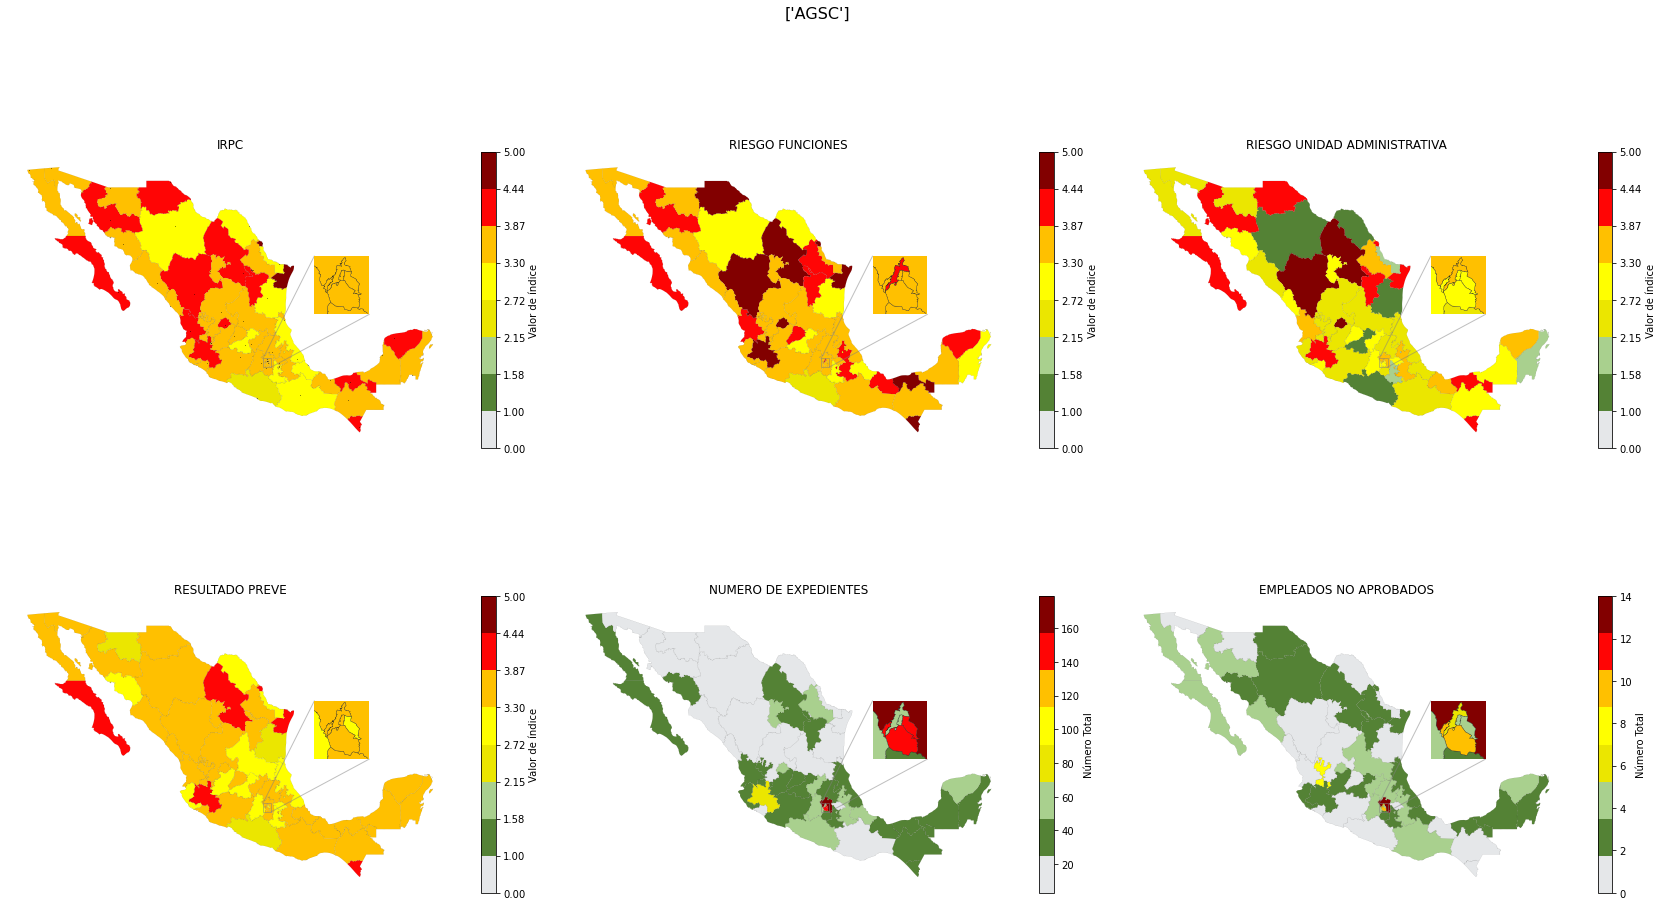

In [9]:
#-------------------------------------------------------------------------------------------------------------------------#
#### Ejecucion de funcion Spatial_Maps_01
Spatial_Maps_01(Geo_spatial, output_dataframe, GeoLocations)
#-------------------------------------------------------------------------------------------------------------------------#

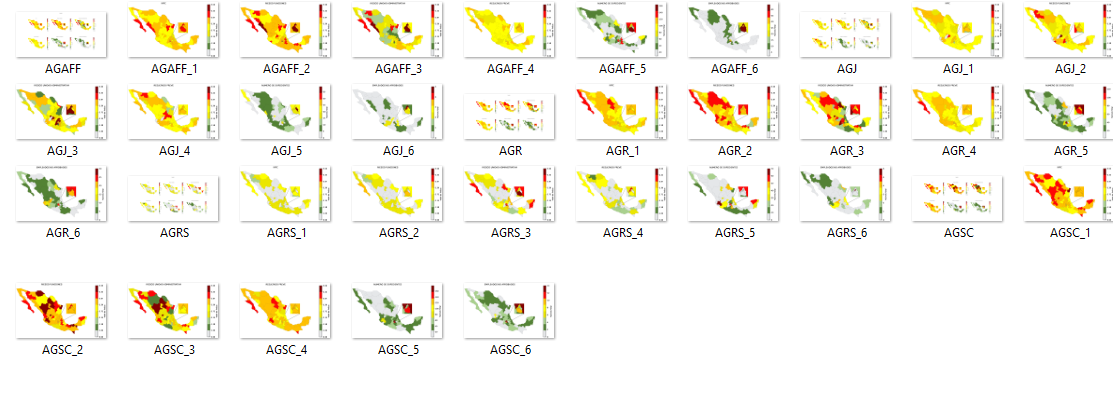